# COGS516 - Assignment 2

Please enter your **name, surname** and **student number** instead of `"NAME-HERE"`, `"SURNAME-HERE"`, `"NUMBER-HERE"` below

In [1]:
student = {
    'name' : "Abdullah Burkan" ,
    'surname' : "Bereketoğlu", 
    'studentNumber' : "2355170"
}

print(student)

In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az

*Use PyMC3 probabilistic programming language to build the models and compute their posteriors.*

## Part 1 - Cognitive Load and Pupil Size (55)

**Increased cognitive load grows pupil size** (Mahtot, 2018). The dataset in `pupil.csv` is from the Wahn et al.'s (2016) object tracking experiments, in which the subject tracks randomly moving objects on a computer screen. Firstly, the target objects are shown to the subject. Then the objects move randomly across the screen with other objects. After some time, the objects stop, and the subject identifies the target objects. 

<div>
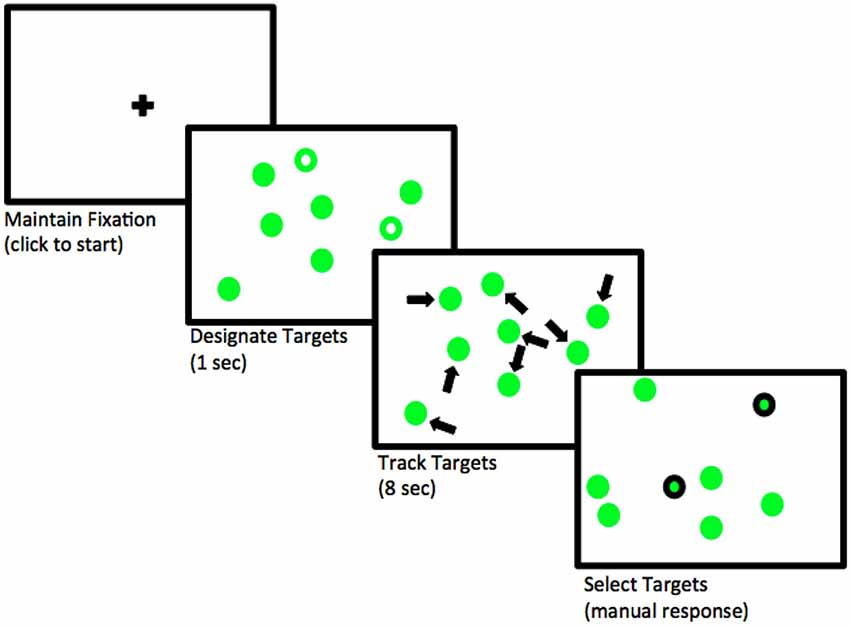
</div>

Our goal is to examine how the number of moving objects affects pupil size. 

In the `pupil.csv` dataset `load` is the number of moving objects, and `p_size` is the pupil size

In [3]:
dpupil = pd.read_csv("pupil.csv")
dpupil.head()

,trial,load,p_size
0,1,2,1021.408566
1,2,1,951.434880
2,3,5,1063.956947
3,4,4,913.487077
4,5,0,602.686850


In [4]:
az.summary(dpupil.to_dict(orient='list'), kind='stats')

,mean,sd,hdi_3%,hdi_97%
trial,21.000,11.979,1.000,39.000
load,2.439,1.704,0.000,5.000
p_size,701.058,136.076,455.479,951.435


a) Draw a DAG for the underlying causal assumptions of your analysis. DAG will include variable $L$ for `load` and $P$ for `p_size`. (5)

> *You can need to use a graph library for drawing the DAG. There are many alternatives.*

In [5]:
import networkx as nx

In [6]:
graph = nx.DiGraph()
graph.add_edges_from([("L","P")])

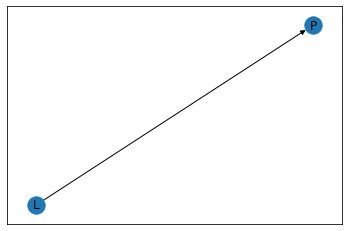

In [7]:
plt.tight_layout()
nx.draw_networkx(graph, arrows=True)

# reference to https://mungingdata.com/python/dag-directed-acyclic-graph-networkx/

In [8]:
list(nx.topological_sort(graph))

['L', 'P']

b) Build a linear regression model for the relation between load and pupil  size. Show that 50 regression lines based purely on your priors in the model. (20)

In [9]:
# just to learn I put dpupil.p_size to understand how does this work.
max(dpupil.load)

5

In [10]:
with pm.Model() as hw_2:
    alpha = pm.Normal('alpha', mu = 800, sigma = 150)
    beta = pm.Normal('beta', mu = 100, sigma = 150)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    mu = alpha + beta*(dpupil.load - dpupil.load.mean())
    w = pm.Normal('W', mu = mu,  sigma = sigma, observed = dpupil.p_size)

1) We don't choose beta as lognormal because as in the head of data set, we can say that for some smaller load size, pupil size can be bigger than some other bigger load size, which gives us the fact that regression line can be on a downward trend.

2) Secondly, from the first five rows I assumed mu as 800 and sigma as 150 for alpha, beta mu as 100 but the standard deviation as 150 since values can also get 1000s and 500s.

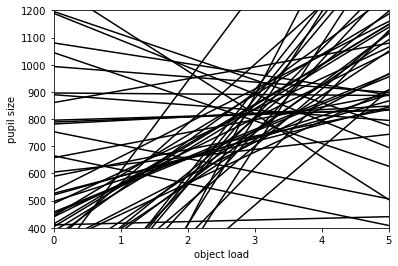

In [11]:
N = 50
alpha = np.random.normal(800, 150, N)
beta = np.random.normal(100, 150, N) # values are changing from near 500 to 1100, so beta is large.
Hbar = 3 # load takes integer value so I rounded my expectation as 2.5 to 3.
Hseq = np.linspace(0, 5, 11)

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(Hseq, alpha[i] + beta[i]*(Hseq - Hbar), "k")
    ax.set_xlim(0, 5)
    ax.set_ylim(400, 1200)
    ax.set_xlabel("object load")
    ax.set_ylabel("pupil size")

c) Compute the posterior parameters of the regression model. Print the summary statistics for the posterior parameters. Draw the plots of posterior parameter densities. (10)

In [12]:
with hw_2:
    trace_hw2_reg = pm.sample(1000, tune = 1000, return_inferencedata= True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [13]:
az.summary(trace_hw2_reg, kind = "stats")

,mean,sd,hdi_3%,hdi_97%
alpha,701.051,1.580,698.109,704.042
beta,34.316,0.934,32.652,36.094
sigma,9.998,0.002,9.995,10.000


array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

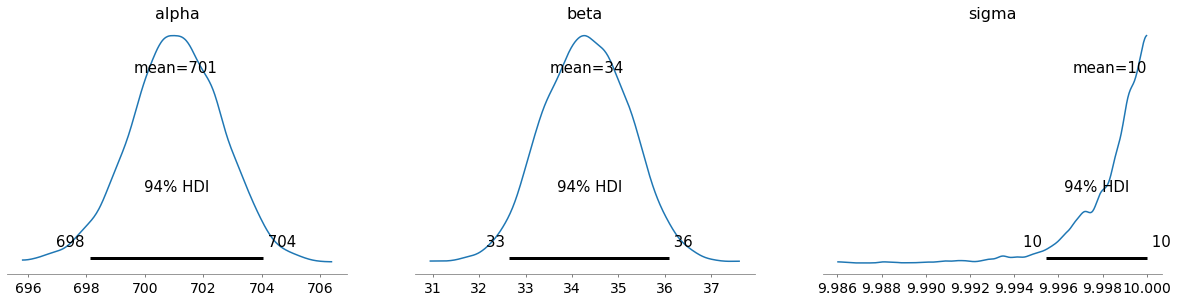

In [14]:
az.plot_posterior(trace_hw2_reg, hdi_prob=0.94)

d) Provide predicted weights and 92% density intervals when there is 0, 1, 2 and 3 objects (*you need to do posterior predictive analysis, you can do interventions if you want, or you need to sample posteriors with these conditions*).  Fill in the table below: (20)

| `load` | expected `p_load` |              92% HDI               |
| ------ | ----------------- | ---------------------------------- |
| 0      |        617        |    [612.72435254 622.23341422]     |
| 1      |        652        |    [648.178967  655.3354268]       |
| 2      |        686        |    [683.20684507 688.85091259]     |
| 3      |        720        |    [717.25412111 723.1994657 ]     |



In [15]:
load_seq = np.arange(0, 5)
samples_x = trace_hw2_reg.posterior.to_dataframe()
mu_pred = np.zeros((len(load_seq), len(samples_x)))
for i, w in enumerate(load_seq):
    mu_pred[i] = samples_x["alpha"] + samples_x["beta"] * (w - dpupil.load.mean())

In [16]:
for i in range(4):
    print(az.hdi(mu_pred[i], hdi_prob=0.92))

[612.72435254 622.23341422]
[648.178967  655.3354268]
[683.20684507 688.85091259]
[717.25412111 723.1994657 ]


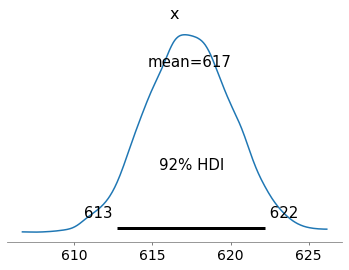

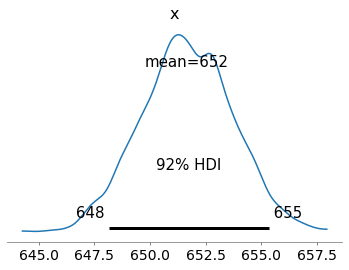

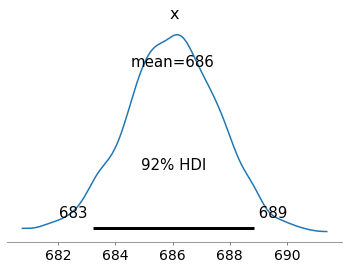

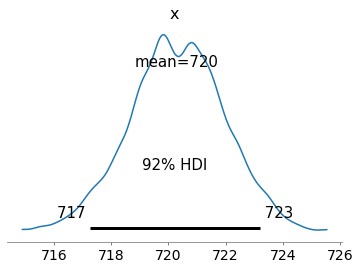

In [17]:
for i in range(4):
    az.plot_posterior(mu_pred[i], hdi_prob=0.92)

<AxesSubplot:title={'center':'x'}>

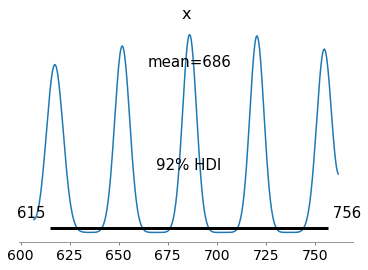

In [18]:
az.plot_posterior(mu_pred, hdi_prob=0.92)

e) Show the posterior predictive distribution of the difference of the pupil size `load = 4` and pupil size `load = 1`. (10)

$$p(p\_{size} | load = 4) - p(p\_{size} | load = 1)$$

In [19]:
pl1 = mu_pred[1]
pl4 = mu_pred[4]

l4_1 = pl4-pl1

mean_high = np.mean(pl4 > pl1)

Text(97, 0.06, '0%')

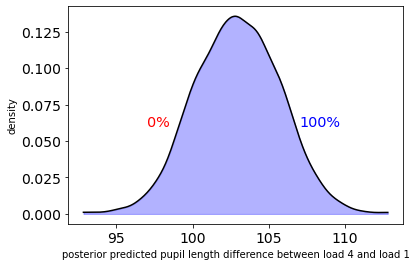

In [22]:
ax = az.plot_dist(l4_1,color="k")
ax.set_xlabel("posterior predicted pupil length difference between load 4 and load 1")
ax.set_ylabel("density")

l1 = ax.lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
ax.fill_between(x1[x1>0],y1[x1>0], color="blue", alpha=0.3)
ax.fill_between(x1[x1<0],y1[x1<0], color="red", alpha=0.3)
ax.text(107,0.06,"{0:.0f}%".format(mean_high * 100), color = "blue", fontsize= "x-large")
ax.text(97,0.06,"{0:.0f}%".format((1 - mean_high) * 100), color = "red", fontsize= "x-large")

## Part 2  - Powerpose and Testerone (45)

The `powerpose.csv` dataset (Fosse ,2016) shows the testerone measurements of 39 people, before and after they were assigned to a treatment. The treatment refers to have a high power pose or low power pose. 

- `hptreat`: Powerpose treatment, `1` is high power pose, `0` is low power pose. 
- `female`: Sex, `1` is female, `0` male
- `age`: Age, in years.
- `testm1`: testerone level before treatment, in picograms per milileter (pg/ml)
- `testm2`: testerone level after treatment, in picograms per milileter (pg/ml)


In [42]:
dpower = pd.read_csv("powerpose.csv")
dpower.head()

,id,hptreat,female,age,testm1,testm2
0,29,1,0,19,38.724998,62.375000
1,30,0,1,20,32.770000,29.235001
2,31,1,1,20,32.320000,27.510000
3,32,0,1,18,17.995001,28.655001
4,34,0,1,21,73.580002,44.669998


In [39]:
az.summary(dpower.to_dict(orient='list'), kind='stats')

,mean,sd,hdi_3%,hdi_97%
id,52.462,13.772,29.000,72.000
hptreat,0.513,0.506,0.000,1.000
female,0.667,0.478,0.000,1.000
age,21.282,3.713,18.000,28.000
testm1,49.842,27.667,17.995,104.815
testm2,50.006,27.469,10.430,105.485


The research question is that on average, assigning a subject a high power pose vs. a low power pose will lead to higher testosterone levels after treatment. 

Build a linear regression model to investigate this claim. Note that, you will need to define a new varaible that represents the change in testerone.

a) Draw a DAG for the underlying causal assumptions of your analysis. (5)

> *You can need to use a graph library for drawing the DAG. There are many alternatives.*

In [31]:
import networkx as nx

graph2 = nx.DiGraph()
graph2.add_edges_from([("TT","DBA")])

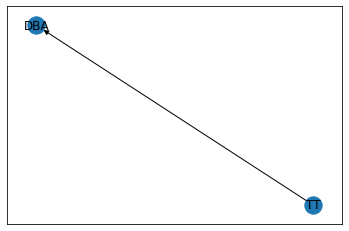

In [32]:
plt.tight_layout()
nx.draw_networkx(graph2, arrows=True)

# reference to https://mungingdata.com/python/dag-directed-acyclic-graph-networkx/

b) Describe what your DAG describes, and justifiy your assumptions in the DAG below: (5)

---

**DBA is the Difference between before and after treatment scores, and TT is the Treatment Type that is applied whether it is high power pose or low power pose.**

**We are questioning that whether difference between before and after treatment scores (DBA) is dependent on high power pose and low power pose.**

**As from the head of the data, we can see that we can't clearly state that there is a dependency on being female or male on before and after treatment differences, also one may expect that females have low testosterone which is contrary to that belief in the prior belief, so we can't put gender as a dependency of the difference in DAG.**

**Also age is as seen from the data, doesn't necessarily effect the DBA or before treatment or after treatment results at all. One can directly look at id 30 and id 29 to see that, while id 29 had bigger before treatment score id 30 did not have. On the other hand id 34 shows a counterexample to the counter argument can be made which is with age scores get lower, or with gender testosterone levels differ.**

**So, just by looking at the first five data we cannot state that age and gender has effect on the DBA. We also cannot state that treatment type has this effect, but this is what we are investigating. We are investigating the causality of TT on DBA.**

---

c) Build a Bayesian model based on your DAG. Compute the posterior parameters. (15)

In [54]:
DBA = dpower.testm2 - dpower.testm1

### Linear Regression Model

In [66]:
with pm.Model() as hw_2_1:
    alpha = pm.Normal('alpha', mu = 40, sigma = 10)
    beta = pm.Normal('beta', mu = 40, sigma = 10)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    mu = alpha + beta*(dpower.hptreat - dpower.hptreat.mean())
    w = pm.Normal('W', mu = mu,  sigma = sigma, observed = DBA)
    trace_hw2_1_reg = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


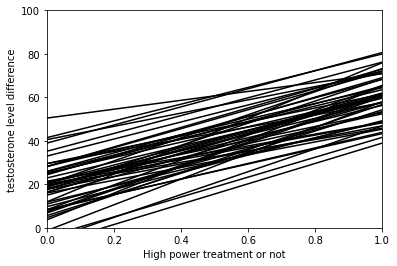

In [67]:
N = 50
alpha = np.random.normal(40, 10, N)
beta = np.random.normal(40, 10, N) 
Hbar = 0.5 # just assumed uniform so H is between 0 and 1 therefore 0.5.
Hseq = np.linspace(0,1,2)

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(Hseq, alpha[i] + beta[i]*(Hseq - Hbar), "k")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 100)
    ax.set_xlabel("High power treatment or not")
    ax.set_ylabel("testosterone level difference")

In [68]:
az.summary(trace_hw2_1_reg, kind = "stats")

,mean,sd,hdi_3%,hdi_97%
alpha,1.150,1.608,-1.945,4.142
beta,11.760,3.041,6.060,17.320
sigma,9.916,0.081,9.764,10.000


array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

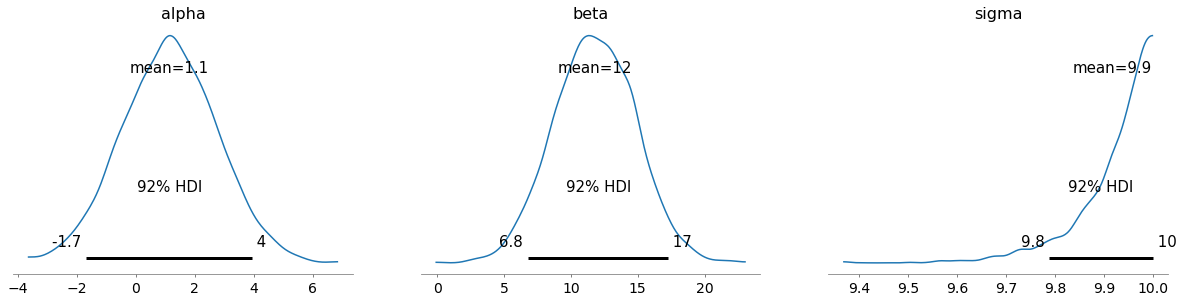

In [69]:
az.plot_posterior(trace_hw2_1_reg, hdi_prob=0.92)

### Difference Model {extra}
Model for $TT \rightarrow DBA$

In [55]:
with pm.Model() as hw_2_2:
    alpha = pm.Normal('alpha', mu = 40, sigma = 10,shape = 2)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    mu = alpha[dpower.hptreat]
    w = pm.Normal('W', mu = mu,  sigma = sigma, observed = DBA)
    trace_hw2_2 = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [56]:
az.summary(trace_hw2_2, kind = "stats", var_names = ["alpha","sigma"])

,mean,sd,hdi_3%,hdi_97%
alpha[0],-2.155,2.260,-6.485,1.901
alpha[1],6.167,2.196,2.099,10.377
sigma,9.918,0.078,9.775,10.000


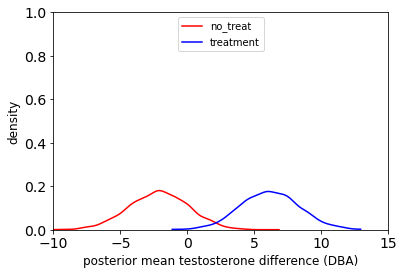

In [61]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_xlabel("posterior mean testosterone difference (DBA)",fontsize=12)
ax.set_ylabel("density",fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)
az.plot_dist(trace_hw2_2.posterior.get("alpha")[:,:,0], ax = ax, color='r',label='no_treat')
az.plot_dist(trace_hw2_2.posterior.get("alpha")[:,:,1], ax = ax, color='b', label='treatment')
ax.set_xlim(-10,15)
ax.set_ylim(0,1)
ax.legend(loc=9)

In [81]:
post = trace_hw2_2.posterior.to_dataframe()

In [82]:
post.alpha.head()

chain  draw  alpha_dim_0
0      0     0              -6.893406
             1               3.036089
       1     0              -1.524346
             1              10.914259
       2     0              -2.068510
Name: alpha, dtype: float64

Text(0, 0.5, 'density')

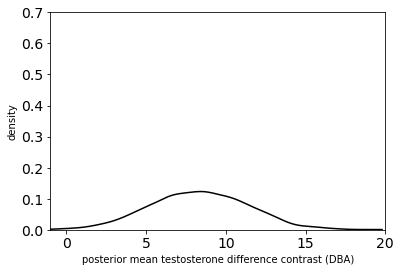

In [84]:
diff = post.alpha[:,:,1] - post.alpha[:,:,0]
ax = az.plot_dist(diff,color="k")
ax.set_xlim(-1, 20)
ax.set_ylim(0,.7)
ax.set_xlabel("posterior mean testosterone difference contrast (DBA)")
ax.set_ylabel("density")

In [85]:
az.summary(diff.to_xarray())

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,8.322,3.122,2.459,13.972,0.055,0.039,3276.0,2839.0,1.0


In [86]:
with pm.Model() as hw_2_3:
    alpha = pm.Normal('alpha', mu = 40, sigma = 10,shape = 2)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    mu = alpha[dpower.hptreat]
    diff = pm.Deterministic('diff', alpha[1] - alpha[0])
    w = pm.Normal('W', mu = mu,  sigma = sigma, observed = DBA)
    trace_hw2_3 = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.88559418625311, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [91]:
DBA_pred = pm.sample_posterior_predictive(trace_hw2_3, 200, hw_2_3)

In [92]:
samples4 = trace_hw2_3.posterior

In [93]:
hpp = np.random.normal(samples4.alpha[:,:,0], samples4.sigma, size = (200,4,1000))
lpp = np.random.normal(samples4.alpha[:,:,1], samples4.sigma,  size = (200,4,1000))
difference = hpp - lpp

(-40.0, 40.0)

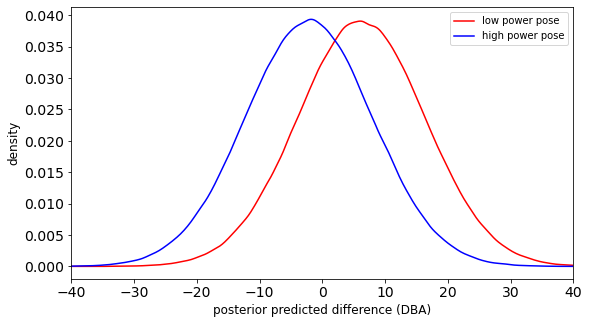

In [97]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_xlabel("posterior predicted difference (DBA)",fontsize=12)
ax.set_ylabel("density",fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)
az.plot_dist(lpp, ax = ax, color='r',label='low power pose')
az.plot_dist(hpp, ax = ax, color='b', label='high power pose')
ax.set_xlim(-40,40)

In [98]:
dba_high = np.mean(hpp > lpp)
print(dba_high)

0.28236625


Text(-40, 0.015, '72%')

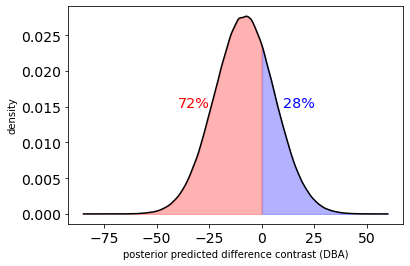

In [128]:
ax = az.plot_dist(difference,color="k")
ax.set_xlabel("posterior predicted difference contrast (DBA)")
ax.set_ylabel("density")

l1 = ax.lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
ax.fill_between(x1[x1>0],y1[x1>0], color="blue", alpha=0.3)
ax.fill_between(x1[x1<0],y1[x1<0], color="red", alpha=0.3)
ax.text(10,0.015,"{0:.0f}%".format(dba_high * 100), color = "blue", fontsize= "x-large")
ax.text(-40,0.015,"{0:.0f}%".format((1 - dba_high) * 100), color = "red", fontsize= "x-large")

d) Do a posterior predictive analysis with interventions. Show the causal effect of powerpose on testerone difference. Compute the testerone difference caused by the interventions $\text{do}(hptreat = 1)$ and $\text{do}(hptreat = 0)$. What is the difference between mean testerone levels and predicted testerone levels between these interventions? Show your results with figures and statistics.  (20)


In [115]:
from theano import shared

In [116]:
hpptreat = dpower.hptreat.values
hptreat_shared = shared(hpptreat)
hptreat_shared

<TensorType(int64, vector)>

In [117]:
with pm.Model() as hw2_4:
    alpha = pm.Normal('alpha', mu = 40, sigma = 10, shape = 2)
    beta = pm.Normal('beta', mu = 40, sigma = 10, shape = 2)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    mu = alpha[hptreat_shared] + beta[hptreat_shared]*(dpower.hptreat - dpower.hptreat.mean())
    w = pm.Normal('W', mu = mu,  sigma = sigma, observed = DBA)
    
    trace_hw2_4 = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [118]:
az.summary(trace_hw2_4, kind = "stats", var_names=["alpha","beta","sigma"])

,mean,sd,hdi_3%,hdi_97%
alpha[0],21.895,4.960,12.735,31.192
alpha[1],-2.924,4.703,-11.544,6.085
beta[0],49.302,8.983,33.296,66.766
beta[1],19.534,8.892,3.278,36.268
sigma,9.920,0.079,9.777,10.000


For predictions, we intervene and make $\text{do(hptreat)=0}$, and get prediction samples.

In [119]:
hpptreat_0 = np.zeros(len(hpptreat),dtype=int)
hptreat_shared.set_value(hpptreat_0)

In [120]:
with hw2_4:
    hw2_4lpp = pm.sample_posterior_predictive(trace_hw2_4)

For predictions, we intervene and make $\text{do(hptreat)=1}$, and get prediction samples.

In [121]:
hpptreat_1 = np.ones(len(hpptreat),dtype=int)
hptreat_shared.set_value(hpptreat_1)

In [122]:
with hw2_4:
    hw2_4hpp = pm.sample_posterior_predictive(trace_hw2_4)

Finally we draw the posterior plot for $P(Testosterone difference \mid \text{do}(hptreat)=1) - P(Testosterone difference \mid \text{do}(hptreat)=0)$

Text(-70, 0.01, '86%')

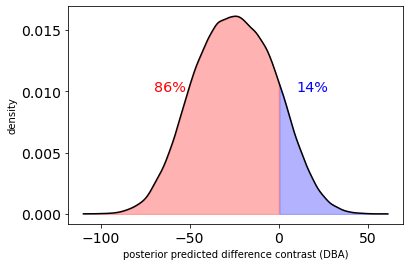

In [131]:
ax = az.plot_dist(hw2_4hpp["W"] - hw2_4lpp["W"], color="k")
ax.set_xlabel("posterior predicted difference contrast (DBA)")
ax.set_ylabel("density")

l1 = ax.lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
ax.fill_between(x1[x1>0],y1[x1>0], color="blue", alpha=0.3)
ax.fill_between(x1[x1<0],y1[x1<0], color="red", alpha=0.3)
ax.text(10,0.01,"{0:.0f}%".format(np.mean((hw2_4hpp["W"] - hw2_4lpp["W"])>0) * 100), color = "blue", fontsize= "x-large")
ax.text(-70,0.01,"{0:.0f}%".format(np.mean((hw2_4lpp["W"] - hw2_4hpp["W"])>0) * 100), color = "red", fontsize= "x-large")

## Submission

Submit your assignment report as a Jupyter notebook markdown file `.ipynb`  format. Your submission should include both textual descriptions (in markdown blocks) and code (in code blocks). Markdown blocks can be formatted in markdown language. [See here](https://guides.github.com/features/mastering-markdown/) to learn more. 

## References

1. Mathot, Sebastiaan. 2018. “Pupillometry: Psychology, Physiology, and Function.” Journal of Cognition 1 (1): 16. https://doi.org/10.5334/joc.18.
1. Fosse, Nathan E. 2016. “Replication Data for ‘Power Posing: Brief Nonverbal Displays Affect Neuroendocrine Levels and Risk Tolerance’ by Carney, Cuddy, Yap (2010).” Harvard Dataverse. https://doi.org/10.7910/DVN/FMEGS6.
1. Wahn, Basil, Daniel P. Ferris, W. David Hairston, and Peter König. 2016. “Pupil Sizes Scale with Attentional Load and Task Experience in a Multiple Object Tracking Task.” PLOS ONE 11 (12): e0168087. https://doi.org/10.1371/journal.pone.0168087.